# Rede Neural Convolutiva

In [1]:
from tensorflow.contrib.tensorboard.plugins import projector
import tensorflow as tf
import os

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


## Configuração da Rede Convolutiva

In [3]:
# Parameters
learning_rate = 0.001
training_iters = 10000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

LOG_DIR='logs'

# Tensorflow Graph

### Definição do Modelo

Criação de wrappers por simplicidade

In [4]:
# Conv2D wrapper, with bias and relu activation
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

# MaxPool2D wrapper
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

### Criação do Modelo

In [5]:
def conv_net(x_1, weights, biases, keep_prob):

    intput = tf.reshape(x_1, shape=[-1, 28, 28, 1], name="input")

    with tf.name_scope('conv1'):
        conv1 = conv2d(intput, weights['w_c1'], biases['b_c1'])
    
    with tf.name_scope('pool1'):
        pool1 = maxpool2d(conv1, k=2)
    
    with tf.name_scope('conv2'):
        conv2 = conv2d(pool1, weights['w_c2'], biases['b_c2'])
    
    with tf.name_scope('pool2'):
        pool2 = maxpool2d(conv2, k=2)
    
    with tf.name_scope('local3'):
        # Reshape conv2 output to fit fully connected layer input
        flat = tf.reshape(pool2, [-1, weights['w_d1'].get_shape().as_list()[0]])
        local3 = tf.add(tf.matmul(flat, weights['w_d1']), biases['b_d1'])
        local3 = tf.nn.relu(local3)
    
    with tf.name_scope('dropout'):
        dropout4 = tf.nn.dropout(local3, keep_prob)
    
    with tf.name_scope('logits'):
        logits = tf.add(tf.matmul(dropout4, weights['w_out']), biases['b_out'])
    
    # Summary
    tf.summary.histogram('conv1', conv1)
    tf.summary.histogram('conv2', conv2)
    tf.summary.scalar('dropout_keep_probability', keep_prob)
    tf.summary.histogram('logits', logits)
    
    return logits

In [6]:
with tf.name_scope('weights'):
    weights = {
        # 5x5 conv, 1 input, 32 outputs
        'w_c1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
        # 5x5 conv, 32 inputs, 64 outputs
        'w_c2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
        # fully connected, 7*7*64 inputs, 1024 outputs
        'w_d1': tf.Variable(tf.random_normal([7*7*64, 1024])),
        # 1024 inputs, 10 outputs (class prediction)
        'w_out': tf.Variable(tf.random_normal([1024, n_classes]))
    }

with tf.name_scope('biases'):
    biases = {
        'b_c1': tf.Variable(tf.random_normal([32])),
        'b_c2': tf.Variable(tf.random_normal([64])),
        'b_d1': tf.Variable(tf.random_normal([1024])),
        'b_out': tf.Variable(tf.random_normal([n_classes]))
    }

### Construção do Modelo

In [7]:
x = tf.placeholder(tf.float32, [None, n_input], name="x")
y = tf.placeholder(tf.float32, [None, n_classes],name="y")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

logits = conv_net(x, weights, biases, keep_prob)

cls = tf.argmax(input=logits, axis=1, name="classes")

### Define a função de custo e otimizador

In [8]:
with tf.name_scope('train'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

### Medidas de desempenho

In [9]:
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [10]:
def variable_summaries(var, key):
    with tf.name_scope(str(key) + '_summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

for key, value in weights.items():
    variable_summaries(weights[key], key)

for key, value in biases.items():
    variable_summaries(biases[key], key)
    
tf.summary.scalar('cross_entropy', cost)  
tf.summary.scalar('accuracy', accuracy)

merged = tf.summary.merge_all()

# Rodamos o modelo

In [14]:
session = tf.Session()
writer = tf.summary.FileWriter(LOG_DIR, session.graph)
session.run(tf.global_variables_initializer())

step = 1

while step * batch_size < training_iters:
    
    x_batch, y_batch = data.train.next_batch(batch_size)
    #TODO: Resolver problemas com run_metada
    #run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
    #run_metadata = tf.RunMetadata()
    
    summary , _ = session.run([merged , optimizer], 
                              feed_dict={x: x_batch, y: y_batch, keep_prob: dropout})#,
#                         options = run_options,
#                         run_metadata=run_metadata)
    
#   writer.add_run_metadata(run_metadata, 'step%03d' % step)
    writer.add_summary(summary, step)

    if step % display_step == 0:
        # Calculate batch loss and accuracy
        loss, acc = session.run([cost, accuracy], feed_dict={x: x_batch, y: y_batch, keep_prob: 1.})
               
        print("Iter " + str(step*batch_size) + \
              ", Minibatch Loss= " + str(loss) + \
              ", Training Accuracy= " + str(acc))
    
    step += 1

writer.close()

print("Otimização Finalizada!")

Iter 1280, Minibatch Loss= 17612.2, Training Accuracy= 0.34375
Iter 2560, Minibatch Loss= 11385.6, Training Accuracy= 0.59375
Iter 3840, Minibatch Loss= 6038.98, Training Accuracy= 0.710938
Iter 5120, Minibatch Loss= 3274.92, Training Accuracy= 0.765625
Iter 6400, Minibatch Loss= 4152.42, Training Accuracy= 0.804688
Iter 7680, Minibatch Loss= 1726.96, Training Accuracy= 0.882812
Iter 8960, Minibatch Loss= 2443.21, Training Accuracy= 0.851562
Otimização Finalizada!


In [15]:
feed_dict_test={x: data.test.images,
           y: data.test.labels,
           keep_prob: 1.}

def print_accuracy():
    acc = session.run(accuracy , feed_dict=feed_dict_test)
    print("Acuracia: {0:.1%}".format(acc) )

In [16]:
print_accuracy()

Acuracia: 86.5%


# Testando o modelo com uma imagem

In [17]:
prediction=tf.argmax(logits,1)

[7]


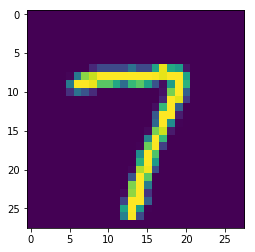

In [18]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
n=100
img_input = data.train.images[n:(n+1)]
img=np.reshape(img_input, (28,28))
plt.imshow(img)
print(session.run(prediction, feed_dict={x: img_input , keep_prob: 1}))